In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tkinter import Tk
from tkinter.filedialog import askopenfilename
from tkinter.filedialog import asksaveasfilename

## XGBoost with Boroughs sin/cos hour and no hotspot score

In [5]:
# Load the cleaned and merged file
Tk().withdraw()
file_path = askopenfilename(title="Select Cleaned Merged CSV with Features")
df = pd.read_csv(file_path)
print("Loaded:", file_path)
print("Shape:", df.shape)

# Log-transform target for regression stability
df['log_fare_per_minute'] = np.log1p(df['fare_per_minute'])

# Also log-transform fare_per_mile if not already done
#df['log_fare_per_mile'] = np.log1p(df['fare_per_mile'])

# Final features (after removing boroughs and time_of_day)
categorical_cols = ['is_airport_trip', 'pickup_borough', 'dropoff_borough']
numeric_cols = [
    #'fare_per_mile',
    'dropoff_zone_hotness',
    'trip_duration_variability',
    #'hotspot_score',  
    'sin_hour',
    'cos_hour'
]
feature_cols = categorical_cols + numeric_cols

# Preprocess datetime and filter rows
df['pickup_date'] = pd.to_datetime(df['pickup_date'])
df = df.dropna(subset=['fare_per_minute'])  # Drop rows with missing original target

# Encode sin/cos hour
df['sin_hour'] = np.sin(2 * np.pi * df['pickup_hour'] / 24)
df['cos_hour'] = np.cos(2 * np.pi * df['pickup_hour'] / 24)
df.drop(columns=['pickup_hour', 'time_of_day'], inplace=True, errors='ignore')

# Detect available months
available_months = sorted(df['pickup_date'].dt.month.unique())
print(" Available months in dataset:", available_months)

# Require at least two months
if len(available_months) < 2:
    raise ValueError(" Need at least two months of data for train/test split.")

# Use first available month for training, second for testing
train_month = available_months[0]
test_month = available_months[1]

print(f" Using month {train_month} for training and {test_month} for testing.")

train_df = df[df['pickup_date'].dt.month == train_month].copy()
test_df = df[df['pickup_date'].dt.month == test_month].copy()

# Preprocess categorical features
X_train_cat = pd.get_dummies(train_df[categorical_cols], drop_first=True)
X_test_cat = pd.get_dummies(test_df[categorical_cols], drop_first=True)
X_test_cat = X_test_cat.reindex(columns=X_train_cat.columns, fill_value=0)

# Final feature matrices
X_train = pd.concat([train_df[numeric_cols].reset_index(drop=True), X_train_cat.reset_index(drop=True)], axis=1)
X_test = pd.concat([test_df[numeric_cols].reset_index(drop=True), X_test_cat.reset_index(drop=True)], axis=1)

# Targets
y_train = train_df['log_fare_per_minute']  # log-transformed for training
y_test = test_df['fare_per_minute']        # original scale for evaluation

# Train model
model = XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

# Predict and invert log transformation
y_pred_log = model.predict(X_test)
y_pred = np.expm1(y_pred_log)  # convert back to original scale

# Evaluate
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
feature_importance = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Output results
print(f"\nTime-Based Evaluation XGBoost (Train: Jan, Test: Feb):")
print(f"R² Score: {r2:.4f}")
print(f"MAE: {mae:.4f}")
print("\nTop Features:")
print(feature_importance.head(10))

Loaded: C:/diksha/Summer Sem/ScoringModel/Data/Hotness and Duration/Data_with_Features_Jun_Jul.csv
Shape: (5815986, 35)
 Available months in dataset: [np.int32(6), np.int32(7), np.int32(8)]
 Using month 6 for training and 7 for testing.

Time-Based Evaluation XGBoost (Train: Jan, Test: Feb):
R² Score: 0.3170
MAE: 0.1871

Top Features:
is_airport_trip              0.588089
dropoff_borough_EWR          0.109982
trip_duration_variability    0.070049
sin_hour                     0.059794
dropoff_borough_Brooklyn     0.032873
pickup_borough_Queens        0.030158
dropoff_borough_Queens       0.026737
pickup_borough_Brooklyn      0.023937
dropoff_borough_Manhattan    0.015928
cos_hour                     0.014152
dtype: float32


## LightGBM with Boroughs sin/cos hour and no hotspot score

In [6]:
# Load the cleaned and merged file
Tk().withdraw()
file_path = askopenfilename(title="Select Cleaned Merged CSV with Features ")
df = pd.read_csv(file_path)
print("Loaded:", file_path)
print("Shape:", df.shape)

# Log-transform target for regression stability
df['log_fare_per_minute'] = np.log1p(df['fare_per_minute'])

# Log-transform fare_per_mile for modeling
#df['log_fare_per_mile'] = np.log1p(df['fare_per_mile'])

# Feature lists
categorical_cols = ['is_airport_trip', 'pickup_borough', 'dropoff_borough']
numeric_cols = [
    #'fare_per_mile',
    'dropoff_zone_hotness',
    'trip_duration_variability',
    #'hotspot_score',
    'sin_hour',
    'cos_hour'
]
feature_cols = categorical_cols + numeric_cols

# Date/time handling
df['pickup_date'] = pd.to_datetime(df['pickup_date'])
df = df.dropna(subset=['fare_per_minute'])

# Add sin/cos hour encodings
df['sin_hour'] = np.sin(2 * np.pi * df['pickup_hour'] / 24)
df['cos_hour'] = np.cos(2 * np.pi * df['pickup_hour'] / 24)
df.drop(columns=['pickup_hour', 'time_of_day'], inplace=True, errors='ignore')

# Detect available months
available_months = sorted(df['pickup_date'].dt.month.unique())
print(" Available months in dataset:", available_months)

# Require at least two months
if len(available_months) < 2:
    raise ValueError(" Need at least two months of data for train/test split.")

# Use first available month for training, second for testing
train_month = available_months[0]
test_month = available_months[1]

print(f" Using month {train_month} for training and {test_month} for testing.")

train_df = df[df['pickup_date'].dt.month == train_month].copy()
test_df = df[df['pickup_date'].dt.month == test_month].copy()

# One-hot encoding for categorical features
X_train_cat = pd.get_dummies(train_df[categorical_cols], drop_first=True)
X_test_cat = pd.get_dummies(test_df[categorical_cols], drop_first=True)
X_test_cat = X_test_cat.reindex(columns=X_train_cat.columns, fill_value=0)

# Final input matrices
X_train = pd.concat([train_df[numeric_cols].reset_index(drop=True), X_train_cat.reset_index(drop=True)], axis=1)
X_test = pd.concat([test_df[numeric_cols].reset_index(drop=True), X_test_cat.reset_index(drop=True)], axis=1)

# Targets
y_train = train_df['log_fare_per_minute']
y_test = test_df['fare_per_minute']  # Original scale for evaluation

# Train LightGBM model
lgb_model = LGBMRegressor(n_estimators=100, random_state=42, n_jobs=-1)
lgb_model.fit(X_train, y_train)

# Predict and invert log transform
y_pred_log = lgb_model.predict(X_test)
y_pred = np.expm1(y_pred_log)

# Evaluate performance
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
feature_importance = pd.Series(lgb_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Output
print(f"\nTime-Based Evaluation LightGBM (Train: Jan, Test: Feb):")
print(f"R² Score: {r2:.4f}")
print(f"MAE: {mae:.4f}")
print("\nTop Features:")
print(feature_importance.head(10))

Loaded: C:/diksha/Summer Sem/ScoringModel/Data/Hotness and Duration/Data_with_Features_Jun_Jul.csv
Shape: (5815986, 35)
 Available months in dataset: [np.int32(6), np.int32(7), np.int32(8)]
 Using month 6 for training and 7 for testing.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.071758 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 571
[LightGBM] [Info] Number of data points in the train set: 3084442, number of used features: 15
[LightGBM] [Info] Start training from score 0.784687

Time-Based Evaluation LightGBM (Train: Jan, Test: Feb):
R² Score: 0.3065
MAE: 0.1888

Top Features:
dropoff_zone_hotness         775
trip_duration_variability    747
cos_hour                     397
sin_hour                     390
pickup_borough_Queens        126
is_airport

## To  Get Feature Importance Values

since we have both lightgbm and xgboost the best way to derive the weights is to normalize and avg the features

We can normalize each models importance (scale them to sum of 1)  and the avg them across the models (this was taken from chatgpt) once we get this we can use combined weights that gives the final weight (%) to apply to each feature in the scoring equation 

In [7]:
# XGBoost importances from the model (already normalized)
xgb_importances = {
    'is_airport_trip': 0.588089,
    'dropoff_borough_EWR': 0.109982,
    'trip_duration_variability': 0.070049,
    'sin_hour': 0.059794,
    'dropoff_borough_Brooklyn': 0.032873,
    'pickup_borough_Queens': 0.030158,
    'dropoff_borough_Queens': 0.026737,
    'pickup_borough_Brooklyn': 0.023937,
    'dropoff_borough_Manhattan': 0.015928,
    'cos_hour': 0.014152
}

# LightGBM raw split count importances from the model
lgb_importances = {
     'dropoff_zone_hotness': 775,
    'trip_duration_variability': 747,
    'cos_hour': 397,
    'sin_hour': 390,
    'pickup_borough_Queens': 126,
    'is_airport_trip': 121,
    'pickup_borough_Manhattan': 97,
    'dropoff_borough_Queens': 91,
    'dropoff_borough_Manhattan': 81,
    'dropoff_borough_Brooklyn': 62
}

# Convert to Series
xgb_series = pd.Series(xgb_importances)
lgb_series = pd.Series(lgb_importances)

# Normalize LightGBM to sum to 1
lgb_normalized = lgb_series / lgb_series.sum()

# Combine and average (only overlapping features will be averaged)
combined_df = pd.concat([xgb_series, lgb_normalized], axis=1, keys=['xgb', 'lgb_norm']).fillna(0)
combined_df['avg_importance'] = combined_df.mean(axis=1)

# Sort by average importance
final_weights = combined_df['avg_importance'].sort_values(ascending=False)

# Display result
print("\n Final Combined Feature Importances:\n")
print(final_weights)



 Final Combined Feature Importances:

is_airport_trip              0.315001
trip_duration_variability    0.164398
dropoff_zone_hotness         0.134222
sin_hour                     0.097441
cos_hour                     0.075832
dropoff_borough_EWR          0.054991
pickup_borough_Queens        0.036901
dropoff_borough_Queens       0.029129
dropoff_borough_Brooklyn     0.027174
dropoff_borough_Manhattan    0.021992
pickup_borough_Manhattan     0.016799
pickup_borough_Brooklyn      0.011968
Name: avg_importance, dtype: float64


These columns like pickup_borough_Queens or dropoff_borough_Brooklyn are how the model understands where the trip starts or ends.

They’re created from the pickup_borough and dropoff_borough values we had in the data.

We need to keep them in the scoring model because the model learned to associate certain boroughs with higher or lower profitability — and each of these one-hot columns has a weight based on how much it contributed during training.

## Function for the Scoring Function

This is the the final feature to now output the score

Auto-selected normalization range: min = 1.57, max = 418.37


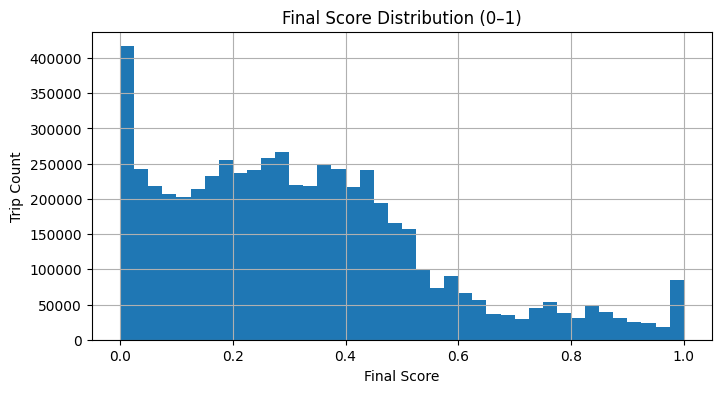


Preview of predicted scores:
   predicted_score  final_score
0       104.002509     0.245750
1         9.987787     0.020185
2        25.785296     0.058087
3        81.563839     0.191914
4       186.627736     0.443989

Top 5 Most Profitable Trips:
              tpep_pickup_datetime      tpep_dropoff_datetime  trip_distance  \
2327251  2023-06-08 12:45:23+00:00  2023-06-08 13:04:11+00:00           1.60   
2327257  2023-06-08 12:45:18+00:00  2023-06-08 13:01:24+00:00           0.70   
2327260  2023-06-08 12:45:17+00:00  2023-06-08 12:56:19+00:00           0.64   
314924   2023-06-27 22:55:09+00:00  2023-06-27 22:59:59+00:00           0.81   
315063   2023-06-27 22:54:01+00:00  2023-06-27 22:58:27+00:00           0.73   

         fare_amount  trip_duration_min pickup_date  pickup_hour_x  \
2327251         17.0          18.800000  2023-06-08              8   
2327257         14.2          16.100000  2023-06-08              8   
2327260         10.7          11.033333  2023-06-08      

In [10]:
# Final combined weights (replace with values from your final feature importance)
combined_weights = {
    'is_airport_trip': 0.315001,
    'trip_duration_variability': 0.164398,
    'dropoff_zone_hotness': 0.134222,
    'sin_hour': 0.097441,
    'cos_hour': 0.075832,
    'dropoff_borough_EWR': 0.054991,
    'pickup_borough_Queens': 0.036901,
    'dropoff_borough_Queens': 0.029129,
    'dropoff_borough_Brooklyn': 0.027174,
    'dropoff_borough_Manhattan': 0.021992,
    'pickup_borough_Manhattan': 0.016799,
    'pickup_borough_Brooklyn': 0.011968
}

#  Create a copy of the working DataFrame
df_scoring = df.copy()

#  Make sure one-hot encoded features exist (e.g., for boroughs)
for feature in combined_weights:
    if feature not in df_scoring.columns:
        df_scoring[feature] = 0  # Fill missing one-hot columns with 0s

#  Define scoring function
def calculate_score(row, weights):
    score = 0
    for feature, weight in weights.items():
        score += row.get(feature, 0) * weight
    return score

#  Apply scoring function
df_scoring['predicted_score'] = df_scoring.apply(lambda row: calculate_score(row, combined_weights), axis=1)

# Use percentiles to avoid outliers dominating the scale
fixed_min = df_scoring['predicted_score'].quantile(0.01)
fixed_max = df_scoring['predicted_score'].quantile(0.99)

print(f"Auto-selected normalization range: min = {fixed_min:.2f}, max = {fixed_max:.2f}")


df_scoring['final_score'] = (
    (df_scoring['predicted_score'] - fixed_min) / (fixed_max - fixed_min)
).clip(0, 1)


plt.figure(figsize=(8,4))
df_scoring['final_score'].hist(bins=40)
plt.title("Final Score Distribution (0–1)")
plt.xlabel("Final Score")
plt.ylabel("Trip Count")
plt.show()

#  Preview scores
print("\nPreview of predicted scores:")
print(df_scoring[['predicted_score', 'final_score']].head())

#  show best/worst trips
print("\nTop 5 Most Profitable Trips:")
print(df_scoring.sort_values('final_score', ascending=False).head())

print("\nBottom 5 Least Profitable Trips:")
print(df_scoring.sort_values('final_score').head())

In [11]:
from IPython.display import display

# Columns to show for presentation
cols = [
    'tpep_pickup_datetime', 'tpep_dropoff_datetime',
    'trip_distance', 'fare_amount', 'trip_duration_min',
    'pickup_borough', 'pickup_zone',
    'dropoff_borough', 'dropoff_zone',
    'predicted_score', 'final_score'
]

# Sort and select top/bottom
top5 = df_scoring.sort_values('final_score', ascending=False).head(5)[cols]
bottom5 = df_scoring.sort_values('final_score').head(5)[cols]

# Display with styled headers
print("\n Top 5 Most Profitable Trips")
display(top5.style.set_caption("Top 5 Trips").format({
    'trip_distance': '{:.2f}',
    'fare_amount': '${:.2f}',
    'trip_duration_min': '{:.1f} min',
    'predicted_score': '{:.2f}',
    'final_score': '{:.2f}'
}))

print("\n Bottom 5 Least Profitable Trips")
display(bottom5.style.set_caption("Bottom 5 Trips").format({
    'trip_distance': '{:.2f}',
    'fare_amount': '${:.2f}',
    'trip_duration_min': '{:.1f} min',
    'predicted_score': '{:.2f}',
    'final_score': '{:.2f}'
}))



 Top 5 Most Profitable Trips


,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,fare_amount,trip_duration_min,pickup_borough,pickup_zone,dropoff_borough,dropoff_zone,predicted_score,final_score
2327251,2023-06-08 12:45:23+00:00,2023-06-08 13:04:11+00:00,1.60,$17.00,18.8 min,Manhattan,Midtown South,Manhattan,Midtown Center,464.19,1.00
2327257,2023-06-08 12:45:18+00:00,2023-06-08 13:01:24+00:00,0.70,$14.20,16.1 min,Manhattan,Murray Hill,Manhattan,Midtown Center,464.24,1.00
2327260,2023-06-08 12:45:17+00:00,2023-06-08 12:56:19+00:00,0.64,$10.70,11.0 min,Manhattan,Garment District,Manhattan,Midtown Center,560.66,1.00
314924,2023-06-27 22:55:09+00:00,2023-06-27 22:59:59+00:00,0.81,$7.20,4.8 min,Manhattan,Upper East Side South,Manhattan,Upper East Side South,432.35,1.00
315063,2023-06-27 22:54:01+00:00,2023-06-27 22:58:27+00:00,0.73,$6.50,4.4 min,Manhattan,Upper East Side North,Manhattan,Upper East Side South,432.29,1.00



 Bottom 5 Least Profitable Trips


,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,fare_amount,trip_duration_min,pickup_borough,pickup_zone,dropoff_borough,dropoff_zone,predicted_score,final_score
158258,2023-06-29 15:58:15+00:00,2023-06-29 16:30:33+00:00,5.90,$28.50,32.3 min,Manhattan,Yorkville West,Bronx,Soundview/Castle Hill,1.35,0.00
4409625,2023-07-18 11:07:54+00:00,2023-07-18 11:30:43+00:00,8.92,$36.60,22.8 min,Queens,LaGuardia Airport,Bronx,Highbridge,1.28,0.00
4409642,2023-07-18 11:07:37+00:00,2023-07-18 11:27:14+00:00,10.39,$41.50,19.6 min,Queens,East Elmhurst,Queens,Queens Village,1.03,0.00
5011459,2023-07-11 21:40:08+00:00,2023-07-11 22:26:39+00:00,9.45,$70.00,46.5 min,Manhattan,Midtown North,Queens,Kew Gardens,1.46,0.00
2369201,2023-06-07 23:21:55+00:00,2023-06-07 23:39:26+00:00,2.85,$17.70,17.5 min,Manhattan,TriBeCa/Civic Center,Brooklyn,Columbia Street,1.39,0.00


| Column            | Meaning                                                                |
| ----------------- | ---------------------------------------------------------------------- |
| `predicted_score` | The raw, weighted sum based on the chosen features and their weights. |
| `final_score`     | The **normalized version**, scaled between 0 and 1 for comparison.     |


How to Use These Scores:
predicted_score is useful if we want to explain how the ride’s components added up.

final_score is the actionable version we can rank or display in the app (e.g., “Choose this ride — it scores 0.82!”).